In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import viz
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList, SkopeRules, IRFClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple_3_splits'
os.makedirs(MODELS_DIR, exist_ok=True)


# load the data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

# split the idxs
train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

# split the data
X, y = df[processed_feats], df[outcome_def]
half = train_idxs.sum() // 2
split_to_plot = '_test2'

# 4-split
# X_train, y_train = X[train_idxs][:half], y[train_idxs][:half]
# X_cv, y_cv = X[train_idxs][half:], y[train_idxs][half:]

# 3-split
X_train, y_train = X[train_idxs], y[train_idxs]
X_cv, y_cv = X_train, y_train

X_test1, y_test1 = X[test_idxs1], y[test_idxs1]
X_test2, y_test2 = X[test_idxs2], y[test_idxs2]
data_sizes = {
    'train': (y_train.sum(), X_train.shape[0]),
    'cv': (y_cv.sum(), X_cv.shape[0]),
    'test1': (y_test1.sum(), X_test1.shape[0]),
    'test2': (y_test2.sum(), X_test2.shape[0]),
}     
def predict_and_save(model, model_name='decision_tree', split_to_plot='_cv'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_test1, X_test2, X_cv], [y_train, y_test1, y_test2, y_cv], 
                            ['_train', '_test1', '_test2', '_cv']):
        sens, spec, threshes = validate.sensitivity_specificity_curve(y,
                                                                      model.predict_proba(x)[:, 1],
                                                                      plot=suffix == split_to_plot)
        plt.title(split_to_plot[1:])
        results['sens' + suffix] = sens
        results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return sens, spec, threshes

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# fit simple models

**decision tree**

100%|██████████| 10/10 [00:00<00:00, 97.70it/s]


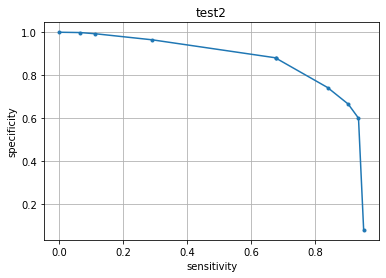

In [15]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(dt, model_name='decision_tree', split_to_plot=split_to_plot)

# visualize
# plt.figure(dpi=300)
# plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

**bayesian rule list**

training bayesian_rule_list...


100%|██████████| 5/5 [00:00<00:00, 97.03it/s]


Trained RuleListClassifier for detecting IwI
IF AbdTenderDegree_None : 0.5_to_inf AND GCSScore_Full_yes : 0.5_to_inf THEN probability of IwI: 0.3% (0.2%-0.5%)
ELSE IF Hypotension_yes : 0.5_to_inf THEN probability of IwI: 25.0% (16.0%-35.3%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 AND ThoracicTrauma_yes : -inf_to_0.5 THEN probability of IwI: 1.4% (1.0%-1.9%)
ELSE IF GCSScore_Full_yes : 0.5_to_inf THEN probability of IwI: 4.7% (3.3%-6.3%)
ELSE probability of IwI: 14.2% (10.2%-18.7%)



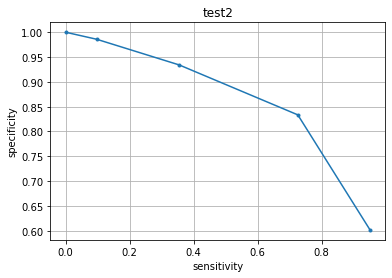

In [28]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = RuleListClassifier(max_iter=20000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = predict_and_save(brl, model_name='bayesian_rule_list', split_to_plot=split_to_plot)
print(brl)

**rulefit**

In [ ]:
# fit a rulefit model
np.random.seed(13)
rulefit = RuleFit()
rulefit.fit(X_train, y_train, feature_names=processed_feats)

# preds = rulefit.predict(X_test)
sens, spec, threshes = predict_and_save(rulefit, model_name='rulefit', split_to_plot=split_to_plot)
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''
# print(sklearn.metrics.classification_report(y_test, preds))
rules = rulefit.get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
print(rules)

**slim - sparse linear integer model**

In [ ]:
fewest_feats = data.fewest_feats
CLASS_WEIGHT = 100
n = X_train.shape[0]
lambda_reg = 10

# optionally upweight positive samples
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
X_train_small = X_train[fewest_feats]
slim = SLIM()
slim.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=lambda_reg,
         sample_weight=sample_weight)

# calculate mse on the training data
# sens, spec, threshes = predict_and_save(slim, model_name='slim')

X_test_small = X_test1[fewest_feats]
# preds = slim.predict(X_test_small)
# preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
preds_proba = slim.predict_proba(X_test_small)
print('considered ', len(fewest_feats), 'feats')
coefs = slim.model.coef_.astype(int)
intercept = slim.model.intercept_
for i in range(len(fewest_feats)):
    if coefs[i] != 0:
        print(fewest_feats[i], coefs[i])
print('intercept', intercept)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test1, preds_proba[:, 1], plot=True)

**skope rules**

In [ ]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=100,
                 n_estimators=100,
                 precision_min=0.01, # per rule precision min
                 recall_min=0.1,     # per rule recall min
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
sens, spec, threshes = predict_and_save(clf, model_name='skope', split_to_plot=split_to_plot)

plt.show()

**greedy (CART) rule list**

/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1.69 -> AbdTrauma_or_SeatBeltSign_yes -> 0.90 (10081) 5.71 (1963)
0.90 -> DecrBreathSound_yes -> 0.77 (9890) 7.85 (191)
0.77 -> Hypotension_yes -> 0.69 (9764) 7.14 (126)
0.69 -> ThoracicTrauma_yes -> 0.60 (8512) 1.28 (1252)
0.60 -> VomitWretch_yes -> 0.55 (7688) 1.09 (824)
0.55 -> MOI_Motor vehicle collision -> 0.44 (5243) 0.78 (2445)
0.44 -> CostalTender_yes -> 0.38 (4750) 1.01 (493)
0.38 -> MOI_Motorcycle/ATV/Scooter collision -> 0.34 (4430) 0.94 (320)
0.34 -> MOI_Fall from an elevation -> 0.32 (3112) 0.38 (1318)


100%|██████████| 9/9 [00:00<00:00, 66.53it/s]


	                                    => 1.69% risk (12044 pts)
           if AbdTrauma_or_SeatBeltSign_yes ===> 5.7% risk (1963 pts)
	                                    => 0.9% risk (10081 pts)
                     if DecrBreathSound_yes ===> 7.9% risk (191 pts)
	                                    => 0.77% risk (9890 pts)
                         if Hypotension_yes ===> 7.1% risk (126 pts)
	                                    => 0.69% risk (9764 pts)
                      if ThoracicTrauma_yes ===> 1.3% risk (1252 pts)
	                                    => 0.6% risk (8512 pts)
                         if VomitWretch_yes ===> 1.1% risk (824 pts)
	                                    => 0.55% risk (7688 pts)
             if MOI_Motor vehicle collision ===> 0.8% risk (2445 pts)
	                                    => 0.44% risk (5243 pts)
                        if CostalTender_yes ===> 1.0% risk (493 pts)
	                                    => 0.38% risk (4750 pts)
    if MOI_Motorcy

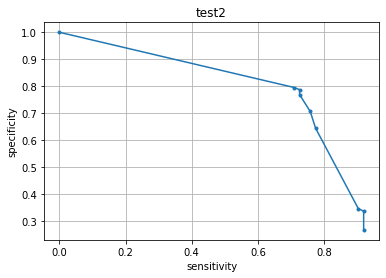

In [19]:
from imodels import GreedyRuleList
class_weight = {0: 1, 1: 1}
d = GreedyRuleList(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, verbose=True)
sens, spec, threshes = predict_and_save(d, model_name='grl', split_to_plot=split_to_plot)
d.print_list()

**irf - iterative Random Forest**

100%|██████████| 324/324 [00:04<00:00, 69.63it/s]


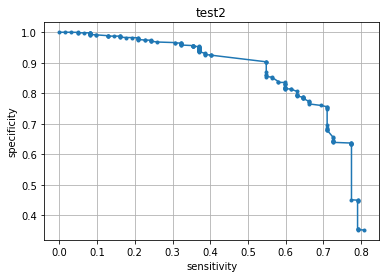

In [20]:
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(irf, model_name='irf', split_to_plot=split_to_plot)
# sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

In [21]:
imps = irf.model.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

MOI_Motorcycle/ATV/Scooter collision 0.026
MOI_Bike collision/fall 0.03
MOI_Object struck abdomen 0.034
AbdDistention_or_AbdomenPain_yes 0.036
MOI_Fall from an elevation 0.039
Age<2_yes 0.051
MOI_Pedestrian/bicyclist struck by moving vehicle 0.058
MOI_Motor vehicle collision 0.061
AbdTenderDegree_None 0.074
Hypotension_yes 0.076
DecrBreathSound_yes 0.077
CostalTender_yes 0.078
ThoracicTrauma_yes 0.085
AbdTrauma_or_SeatBeltSign_yes 0.087
VomitWretch_yes 0.088
GCSScore_Full_yes 0.098


**rf**

In [22]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

rulefit.pkl 95.16 62.61
skope.pkl 98.39 51.65
bayesian_rule_list.pkl 95.16 60.16


/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


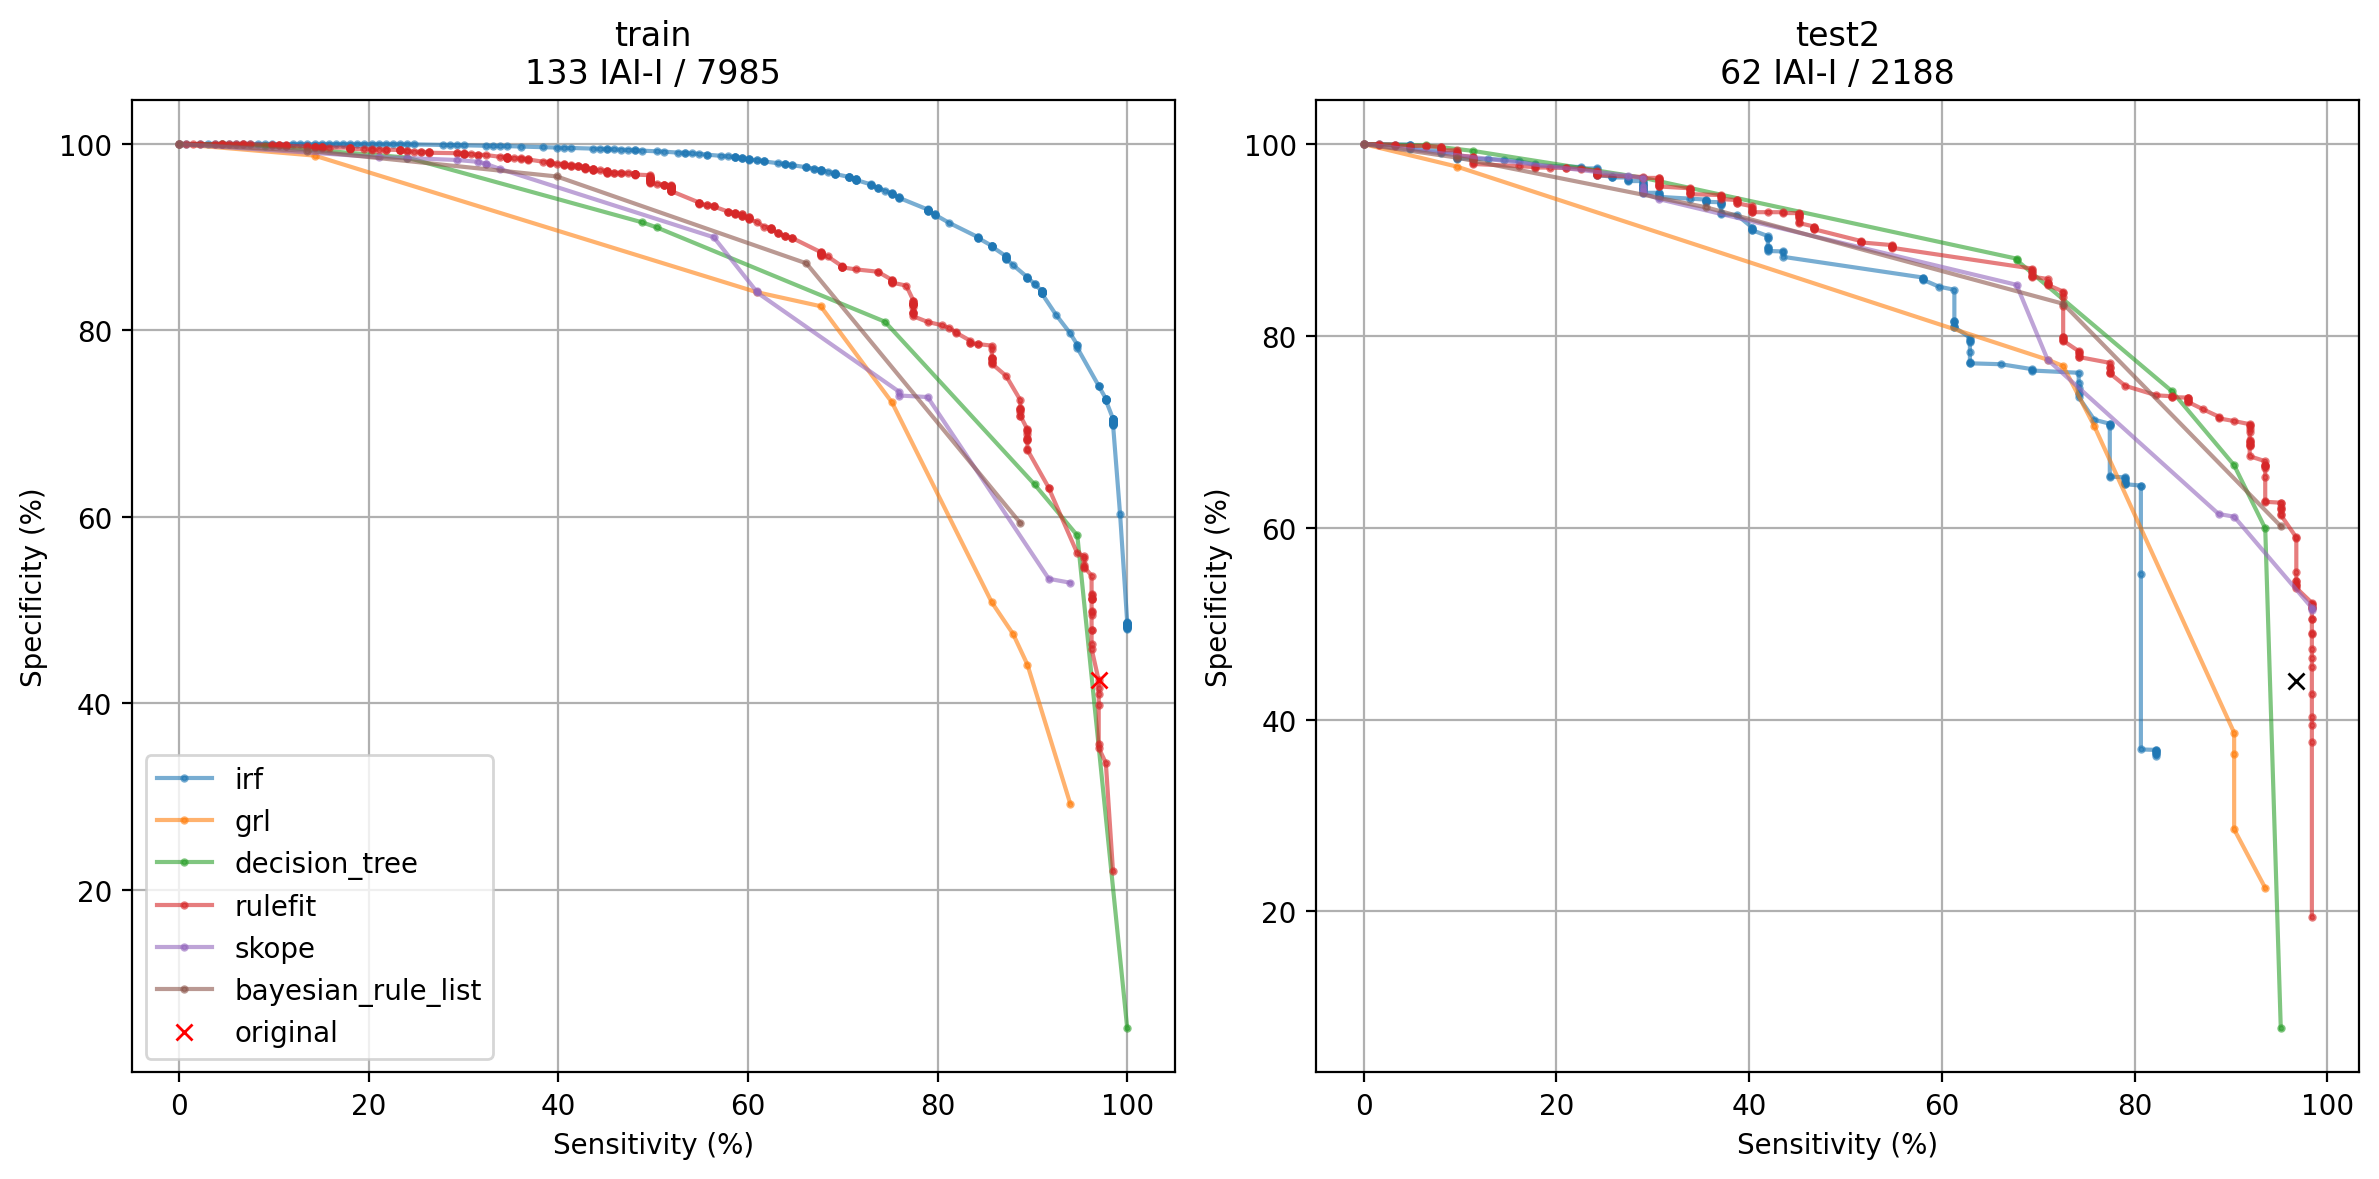

rulefit.pkl 95.16 62.61
skope.pkl 98.39 51.65
bayesian_rule_list.pkl 95.16 60.16


/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


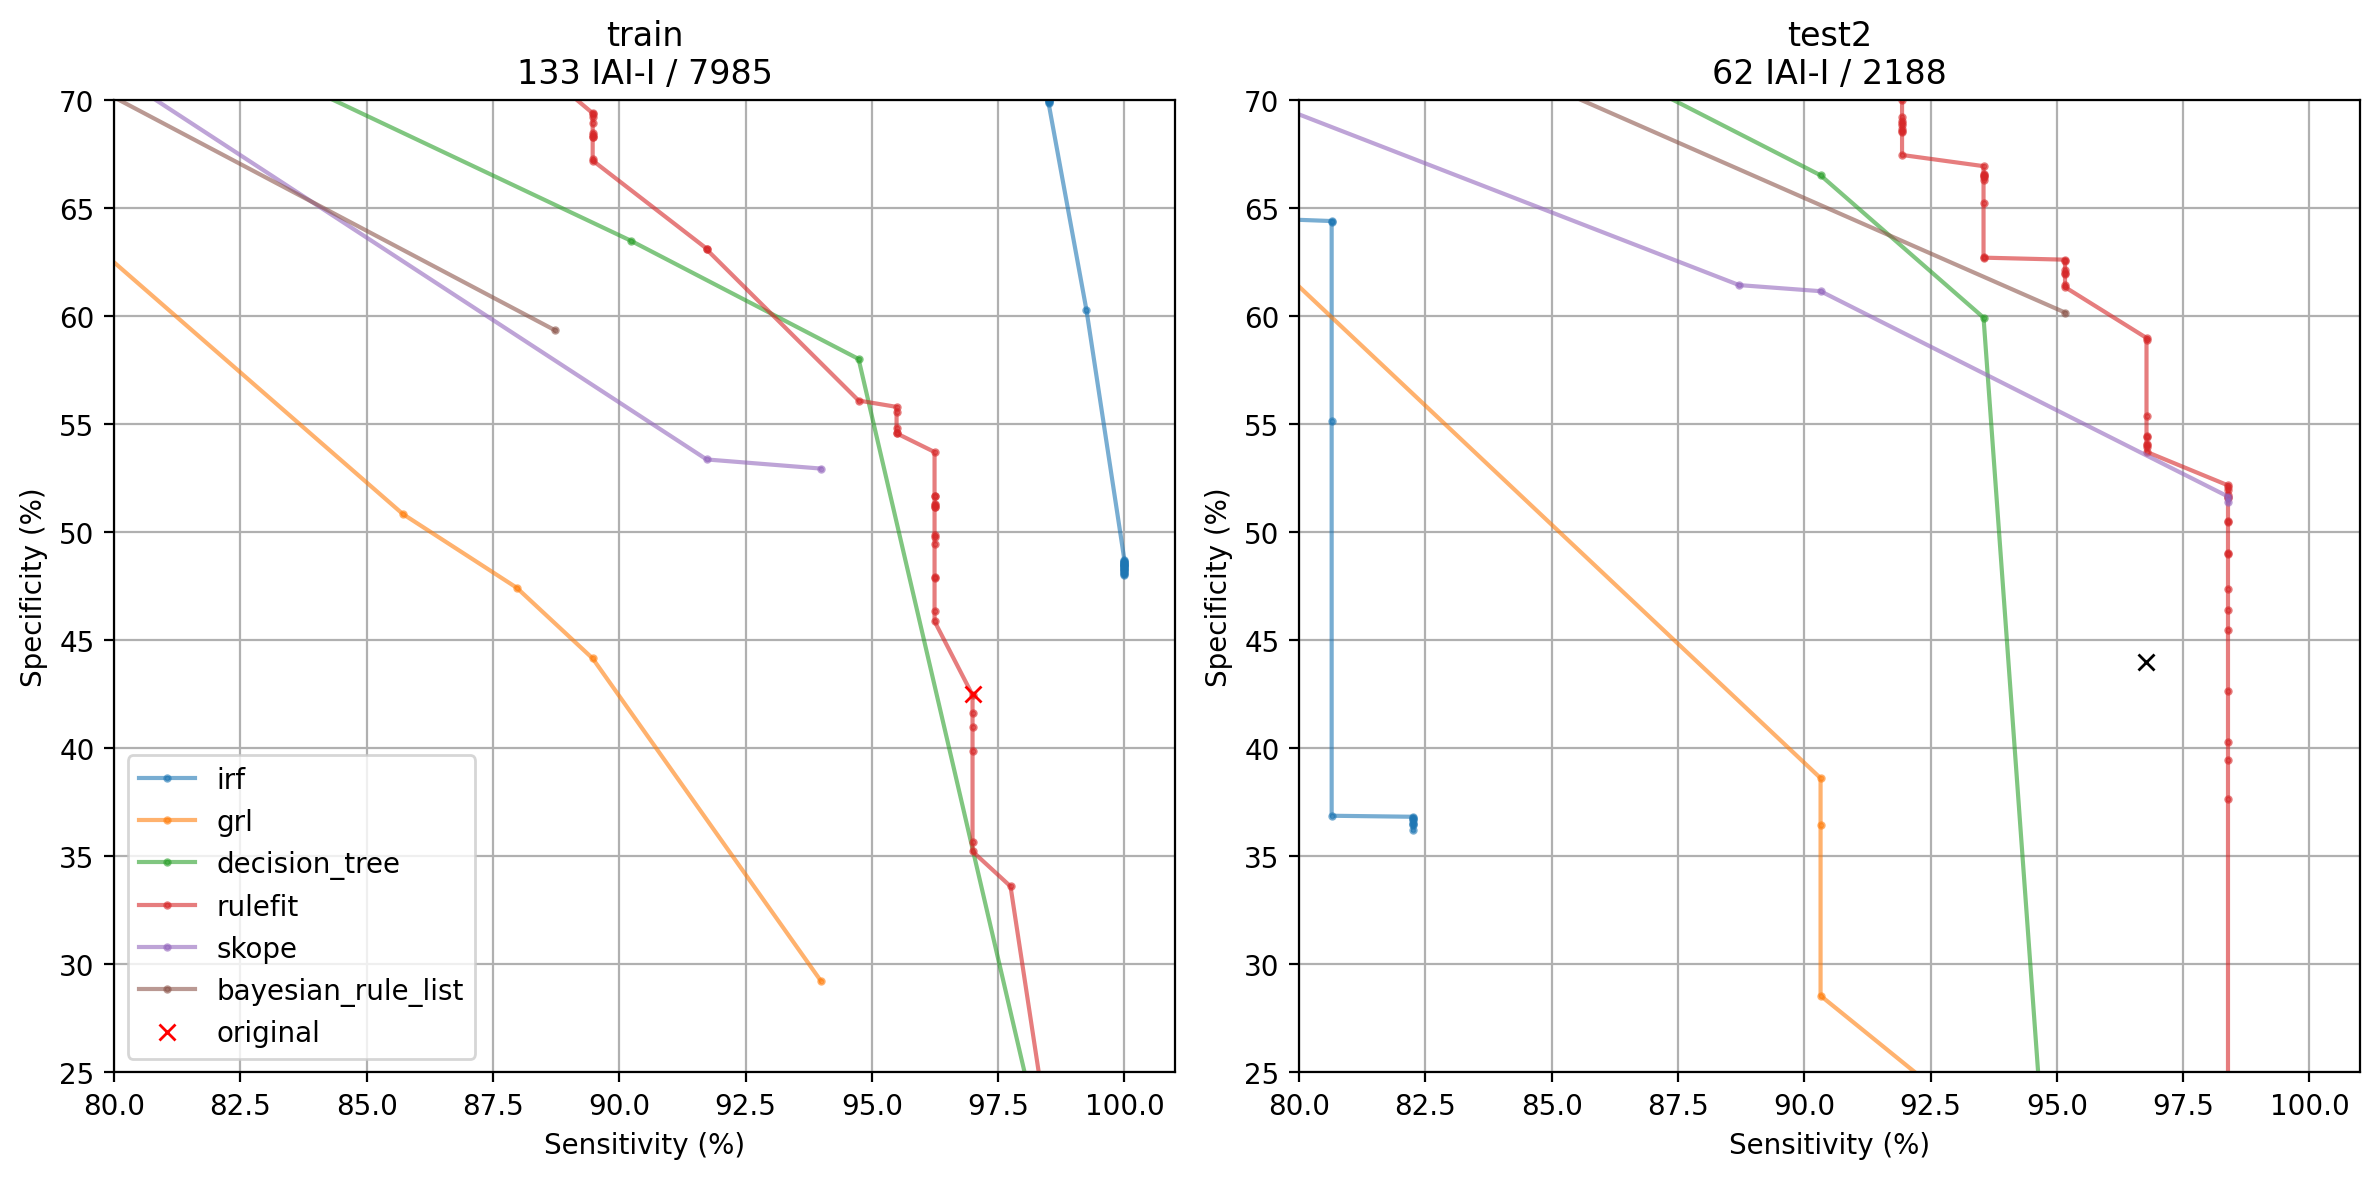

In [37]:
def plot_metrics(suffix):
    for fname in os.listdir(MODELS_DIR):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
        #         print(r)
                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=2)
                plt.xlabel('Sensitivity (%)')
                plt.ylabel('Specificity (%)')
                s = suffix[1:]
                plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                
                # print best results
                if suffix == '_test2': 
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')
                    
    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'x', color='black', label='original')
    else:
        plt.plot(97.0, 42.5, 'x', color='red', label='original')
    plt.grid()



suffixes = ['_train', '_test2'] # _train, _test1, _test2, _cv    
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 6, R * 6))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
plt.tight_layout()
plt.subplot(R, C, 1)
plt.legend()
viz.savefig('metrics_3_splits')
plt.show()

plt.figure(dpi=200, figsize=(C * 6, R * 6))
for i, suffix in enumerate(suffixes):
    plt.subplot(R, C, i + 1)
    plot_metrics(suffix)
    plt.xlim((80, 101))
    plt.ylim((25, 70))
plt.subplot(R, C, 1)    
plt.legend()
plt.tight_layout()
viz.savefig('metrics_3_splits_zoom')
plt.show()